# Plot curvature profile and velocity

# Setup

In [1]:
import os
import subprocess

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

import warnings

warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/nmiolane/code/neuralgeom/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom/neuralgeom


# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import default_config as config
import neuralgeom.datasets.utils as utils
import neuralgeom.models.neural_vae as neural_vae
import train
import viz

INFO:root:Using pytorch backend


# Get config

In [4]:
run_id = "87d52ebd"
expt = "34"

CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    if run_id in config_file:
        print(config_file)

Config in directory: /home/nmiolane/code/neuralgeom/neuralgeom/results/configs:
run_87d52ebd_experimental_34_gain_1.json


In [5]:
with open(
    os.path.join(CONFIG_DIR, f"run_{run_id}_experimental_{expt}_gain_1.json"),
    "r",
) as f:
    config_dict = json.load(f)

# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)
config

{'batch_size': 4,
 'decoder_depth': 10,
 'decoder_width': 200,
 'encoder_depth': 5,
 'encoder_width': 50,
 'lr': 0.0002751022718020967,
 'dataset_name': 'experimental',
 'sweep_name': 'experimental_34_gain_1',
 'expt_id': '34',
 'timestep_microsec': 100000,
 'smooth': True,
 'select_gain_1': True,
 'n_times': None,
 'embedding_dim': None,
 'distortion_amp': None,
 'noise_var': None,
 'manifold_dim': 1,
 'latent_dim': 2,
 'posterior_type': 'hyperspherical',
 'distortion_func': None,
 'n_wiggles': None,
 'radius': None,
 'major_radius': None,
 'minor_radius': None,
 'synthetic_rotation': None,
 'device': 'cuda',
 'log_interval': 20,
 'checkpt_interval': 20,
 'scheduler': False,
 'n_epochs': 150,
 'alpha': 1.0,
 'beta': 0.03,
 'gamma': 30,
 'sftbeta': 4.5,
 'gen_likelihood_type': 'gaussian',
 'gain': 1,
 'run_name': 'run_87d52ebd_experimental_34_gain_1',
 'results_prefix': 'run_87d52ebd_experimental_34_gain_1',
 'data_n_times': 8327,
 'data_dim': 40}

# Get data and curvature profile

In [6]:
dataset_torch, labels, train_loader, test_loader = utils.load(config)
dataset_torch = dataset_torch.to(config.device)
_, data_dim = dataset_torch.shape

INFO:root:# - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt34_times_timestep100000.txt! Loading...
INFO:root:# - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt34_place_cells_timestep100000.npy! Loading...
INFO:root:# - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt34_labels_timestep100000.txt! Loading...


The dataset contains only one gain value: 1.0
Dataset shape: (8327, 40).


(array([20., 10.,  5.,  4.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.12334892, 0.13705517, 0.15076143, 0.16446769, 0.17817394,
        0.1918802 , 0.20558645, 0.2192927 , 0.23299897, 0.24670522,
        0.26041147]),
 <BarContainer object of 10 artists>)

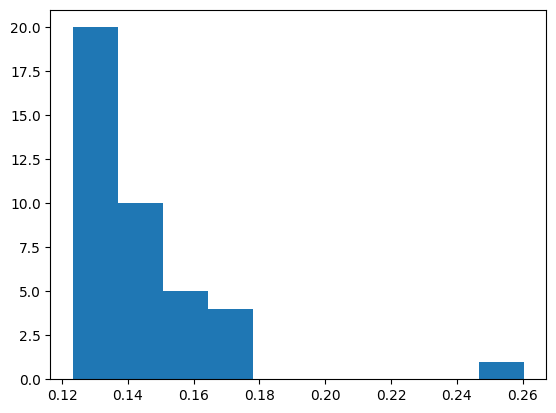

In [7]:
plt.hist(dataset_torch.mean(axis=0).cpu().numpy())

In [8]:
labels

,Unnamed: 0,times,angles,velocities,gains
14,14,3.639397e+08,126.931824,10.274900,1.0
15,15,3.640397e+08,128.266199,16.944754,1.0
16,16,3.641397e+08,130.246521,20.874644,1.0
17,17,3.642397e+08,132.502624,25.055980,1.0
18,18,3.643397e+08,135.161267,28.561179,1.0
...,...,...,...,...,...
29516,29516,3.314140e+09,49.835339,16.836828,1.0
29517,29517,3.314240e+09,51.407605,12.911723,1.0
29518,29518,3.314340e+09,52.489245,11.309622,1.0
29519,29519,3.314440e+09,53.758386,12.342733,1.0


mean: 7.387588335318079
median: 5.921305683624204
std: 4.78014479094774
min: 1.6270675638282055
max: 25.044866732301045


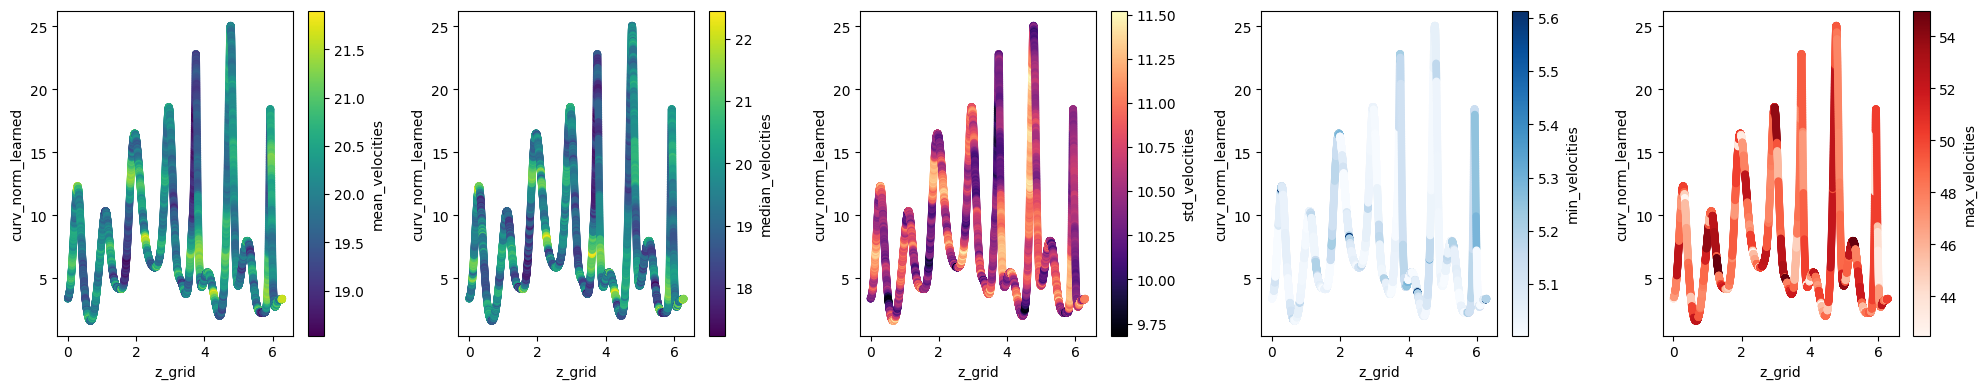

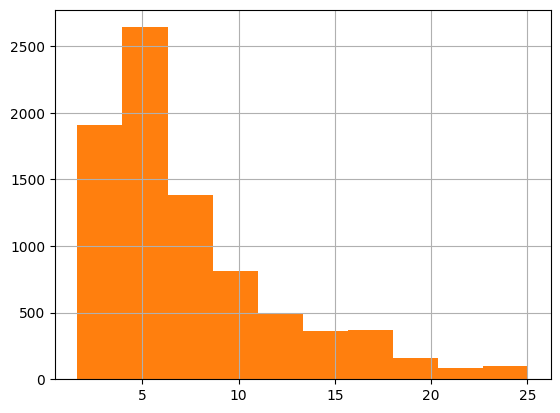

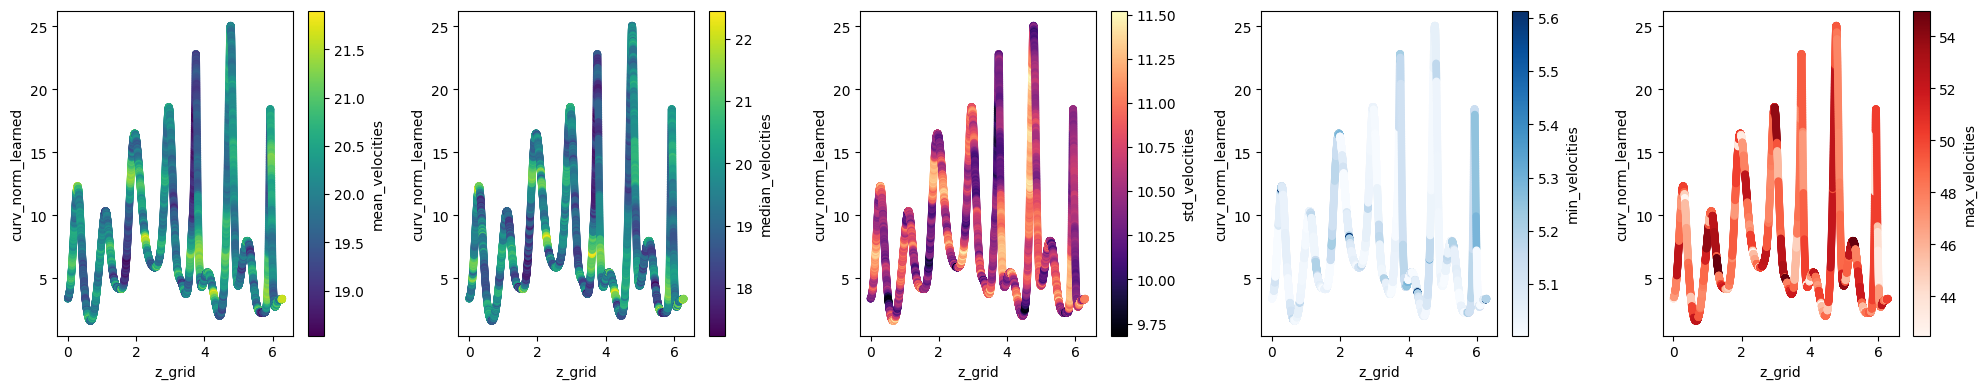

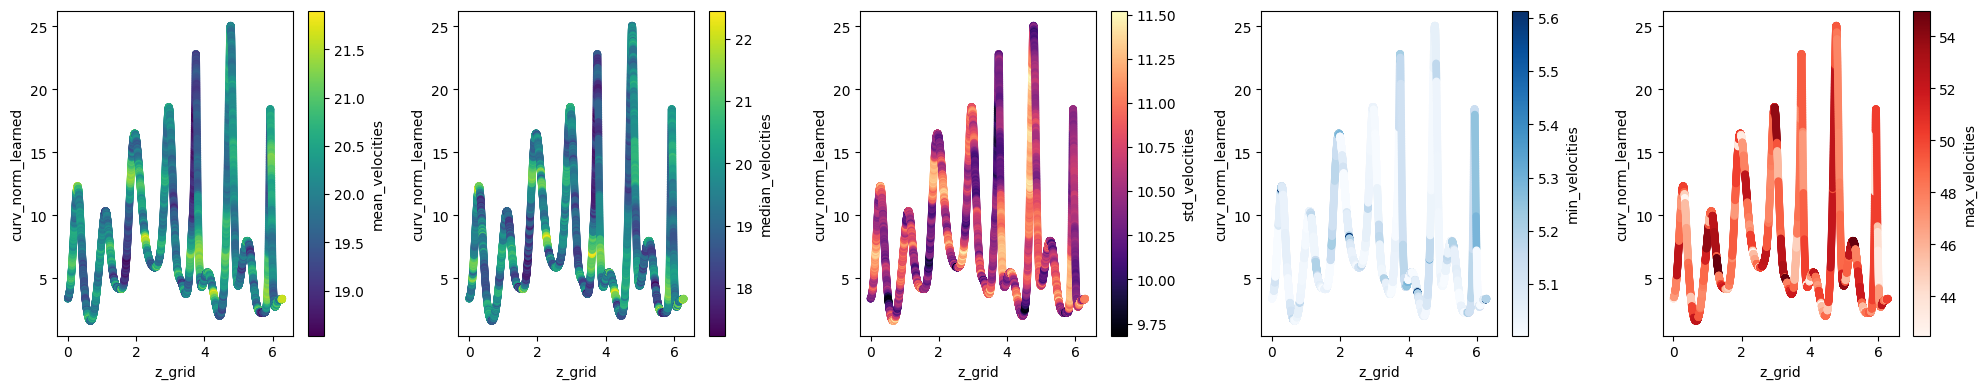

In [9]:
CURVATURE_PROFILES_DIR = os.path.join(os.getcwd(), "results", "curvature_profiles")

curv_norm_learned_profile = pd.read_csv(
    os.path.join(
        CURVATURE_PROFILES_DIR, config.results_prefix + "_curv_norm_learned_profile.csv"
    )
)

curv_norm_learned_profile["curv_norm_learned"].hist()

median = curv_norm_learned_profile["curv_norm_learned"].median()
filtered = curv_norm_learned_profile
# [
#     curv_norm_learned_profile["curv_norm_learned"] < 2 * median
# ]
filtered["curv_norm_learned"].hist()


print("mean:", curv_norm_learned_profile["curv_norm_learned"].mean() )
print("median:", curv_norm_learned_profile["curv_norm_learned"].median())
print("std:", curv_norm_learned_profile["curv_norm_learned"].std())
print("min:", curv_norm_learned_profile["curv_norm_learned"].min())
print("max:", curv_norm_learned_profile["curv_norm_learned"].max())
viz.plot_curvature_velocities(curv_norm_learned_profile, config, labels)
viz.plot_curvature_velocities(filtered, config, labels)

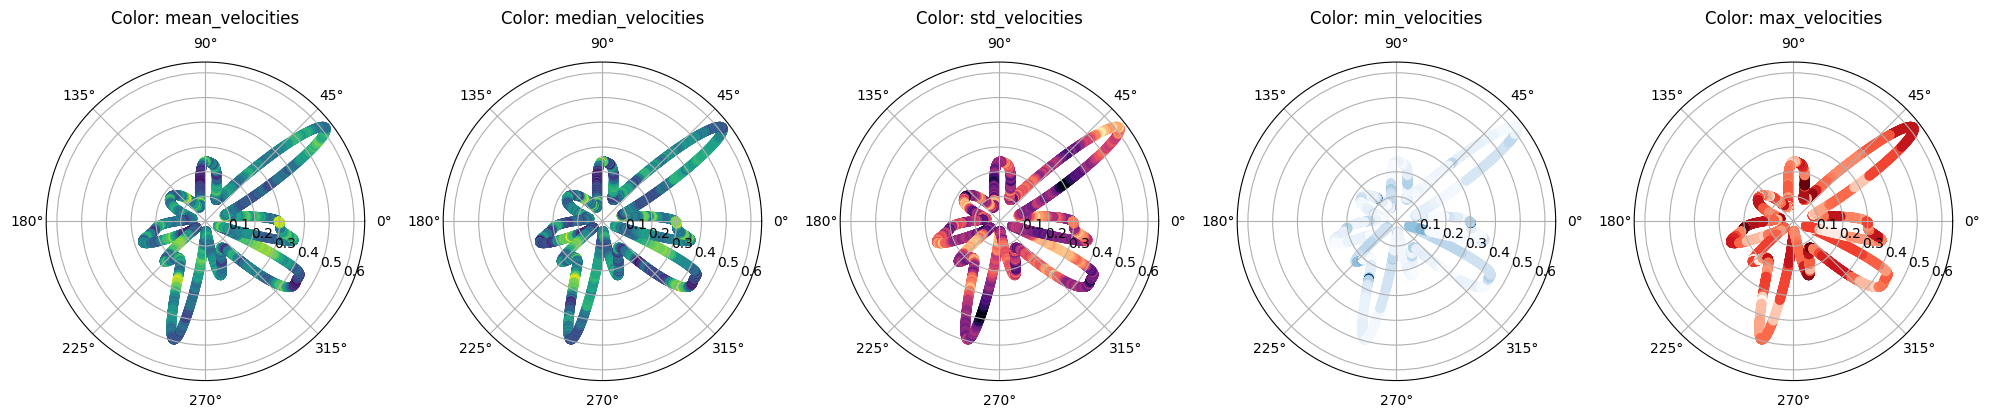

In [10]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np


stats = [
    "mean_velocities",
    "median_velocities",
    "std_velocities",
    "min_velocities",
    "max_velocities",
]
cmaps = ["viridis", "viridis", "magma", "Blues", "Reds"]

fig, axes = plt.subplots(
    nrows=1, ncols=len(stats), figsize=(20, 4), subplot_kw={"projection": "polar"}
)
for i_stat, stat_velocities in enumerate(stats):
    ax = axes[i_stat]
    ax.scatter(
        filtered["z_grid"],
        1/filtered["curv_norm_learned"],
        c=filtered[stat_velocities],
        cmap=cmaps[i_stat],
    )
    #ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.set_title("Color: " + stat_velocities, va="bottom")
fig.tight_layout()

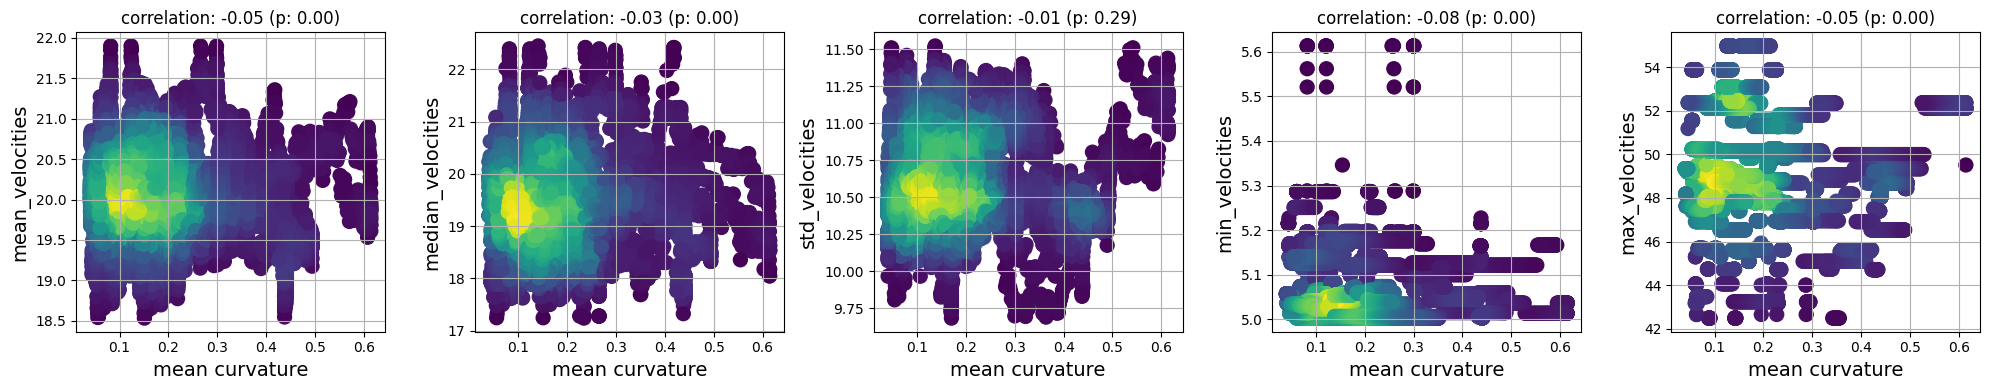

In [36]:
from scipy.stats import gaussian_kde, pearsonr


fig, axes = plt.subplots(nrows=1, ncols=len(stats), figsize=(20, 4))
for i_stat, stat_velocities in enumerate(stats):
    ax = axes[i_stat]
    x = 1/filtered["curv_norm_learned"]
    y = filtered[stat_velocities]
    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    ax.set_xlabel("mean curvature", fontsize=14)
    ax.scatter(x, y, c=z, s=100)
    ax.grid(True)
    ax.set_ylabel(stat_velocities, fontsize=14)
    pears = pearsonr(x, y)
    #print(pears.statistic)
    ax.set_title(f"correlation: {pears.statistic:.2f} (p: {pears.pvalue:.2f})")
fig.tight_layout()